### ARIMA Predictive Analysis

In [22]:
%pip install pandas
%pip install yfinance
%pip install scikit-learn
%pip install projectpro
%pip install plotly
%pip install --upgrade nbformat
%pip install pmdarima


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import yfinance as yf
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta

plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
yf.pdr_override()
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [24]:
now = datetime.now() 
dataset = yf.download('NVDA', now - relativedelta(years=4), now)
print(dataset.head())

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-02-24  67.547501  70.467499  67.000000  68.320000  68.054077   85691600
2020-02-25  69.074997  69.697502  64.489998  65.512497  65.257507  105549600
2020-02-26  65.514999  68.862503  65.500000  66.912498  66.652046   74773200
2020-02-27  63.724998  66.750000  62.222500  63.150002  62.941826   90641600
2020-02-28  60.615002  68.114998  60.447498  67.517502  67.294914  113325200


In [25]:
dataset = dataset.reset_index()
closedf = dataset[['Date','Close']]
closedf = closedf[closedf['Date'] > '2018-09-13']
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

print(closedf.shape)

(1008, 1)


In [26]:
training_size=int(len(closedf))-14
# training_size=int(len(closedf)*0.7)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (994, 1)
test_data:  (14, 1)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6271.909, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6269.957, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6269.958, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6267.769, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6268.340, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.528 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  994
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3137.954
Date:                Sat, 24 Feb 2024   AIC                          -6271.909
Time:                        14:13:37   BIC                          -6262.107
Sample:                             0   HQIC                         -6268.182
                                - 994                                  

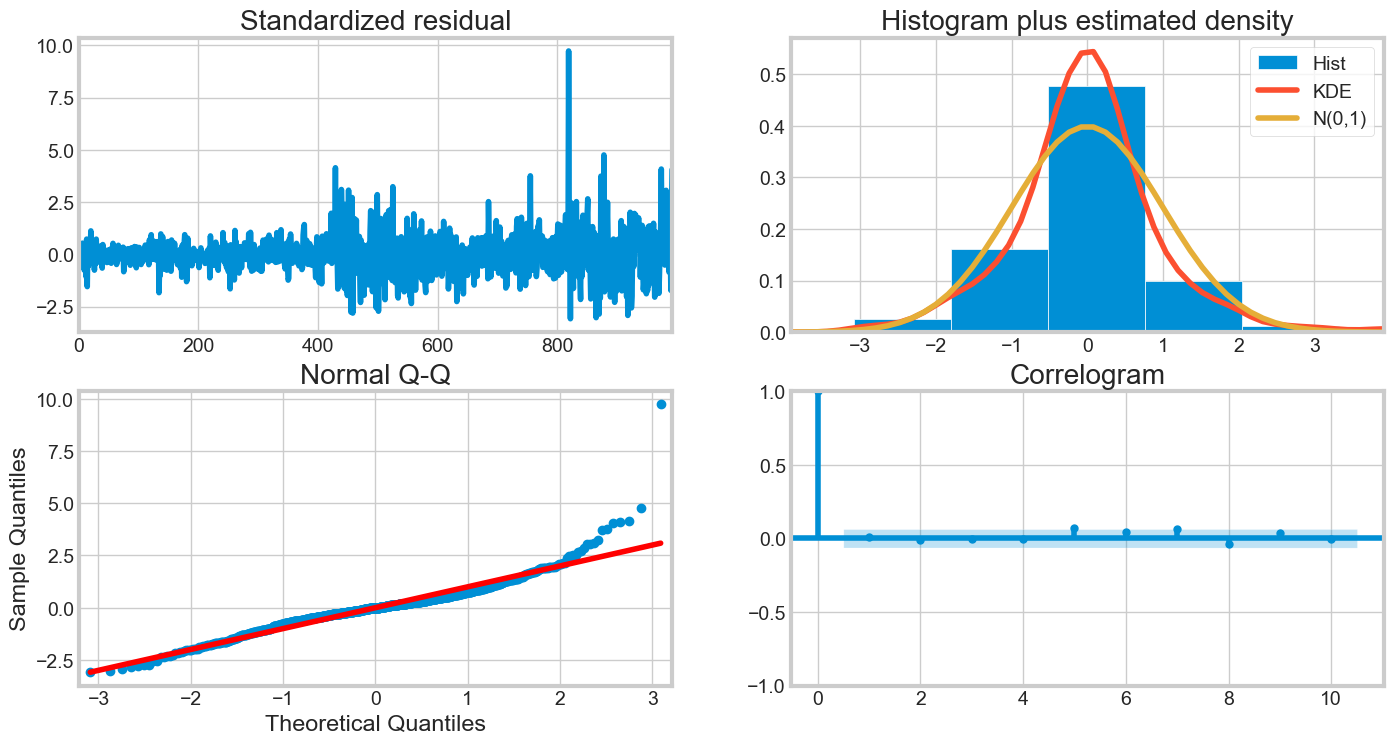

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Forecast:
[0.82955252 0.83036083 0.83116913 0.83197744 0.83278575 0.83359405
 0.83440236 0.83521066 0.83601897 0.83682727]

Confidence Interval:
[[0.80943382 0.84967123]
 [0.80190868 0.85881298]
 [0.79632251 0.86601576]
 [0.79174003 0.87221485]
 [0.78779895 0.87777254]
 [0.78431349 0.88287461]
 [0.78117326 0.88763145]
 [0.77830637 0.89211495]
 [0.77566285 0.89637508]
 [0.77320634 0.90044821]]


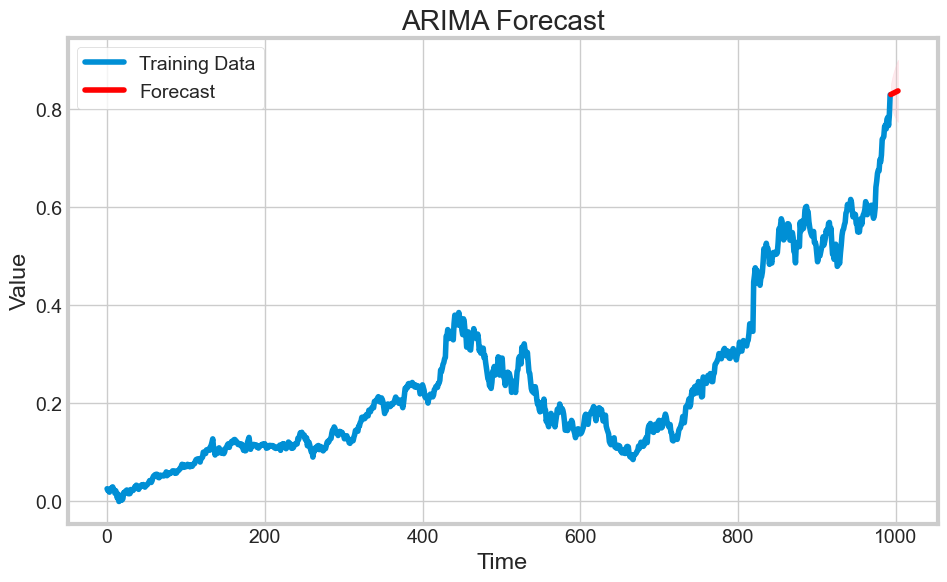

In [37]:
# Forecast
n_periods = 10  # Adjust this according to how many periods ahead you want to forecast
forecast, conf_int = model_autoARIMA.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast
print("Forecast:")
print(forecast)

# Print the confidence interval
print("\nConfidence Interval:")
print(conf_int)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(range(len(train_data), len(train_data) + n_periods), forecast, color='red', label='Forecast')
plt.fill_between(range(len(train_data), len(train_data) + n_periods), conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [42]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(test_data, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   14
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  21.493
Date:                Sat, 24 Feb 2024   AIC                            -40.986
Time:                        14:38:37   BIC                            -40.422
Sample:                             0   HQIC                           -41.103
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0021      0.000      4.939      0.000       0.001       0.003
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                19.11
Prob(Q):                              0.46   Pr

In [48]:
pred = model_fit.forecast(14)
print(pred)


AttributeError: 'numpy.ndarray' object has no attribute 'values'